In [145]:
import json
import requests
import random
import string
import secrets
import time
import re
import collections

try:
    from urllib.parse import parse_qs, urlencode, urlparse
except ImportError:
    from urlparse import parse_qs, urlparse
    from urllib import urlencode

from requests.packages.urllib3.exceptions import InsecureRequestWarning

requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

In [147]:
import gymnasium as gym
from gymnasium.spaces import Text, MultiDiscrete, Discrete, MultiBinary, Tuple
import numpy as np
import random as rnd
import logging
from collections import namedtuple, Counter, defaultdict
import math



In [149]:

import torch
from torch.cuda import init
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler

import time
import logging

#https://huggingface.co/docs/transformers/en/model_doc/decision_transformer
from transformers import DecisionTransformerConfig, DecisionTransformerModel

In [151]:
logger = logging.getLogger('root')
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [153]:
train_dict = open("words_250000_train.txt", 'r').readlines()
word_list = [word.strip() for word in train_dict]


In [155]:
def create_n_word_dictionary(words):
    """
    This function creates a dictionary where keys are word lengths and values are lists of words with that length.
    """
    n_word_dictionary = defaultdict(list)

    for word in words:
        length = len(word)
        n_word_dictionary[length].append(word)

    return dict(n_word_dictionary)

In [157]:
word_count_dict = create_n_word_dictionary(word_list)

In [159]:
# vowel vs. consonants
def count_aeiou(dictionary):
    b05 = 0
    b = [0 for i in range(len(dictionary))]
    b045 = 0
    b055 = 0
    k =11
    for i in range(len(dictionary)):
        b[i] = sum([1 if ltr in 'aeiou' else 0 for ltr in dictionary[i]])/len(dictionary[i])
        if b[i] < 0.55 and len(dictionary[i]) == k:
            b05 += 1
        if b[i] < 0.45 and len(dictionary[i]) == k:
            b045 += 1
    print(b05/len(word_count_dict[k]),b045/len(word_count_dict[k]))
            
    return b

In [161]:
bar = count_aeiou(word_list)
# the 0.45 rule doesn't work for len <= 4 and >= 12
# 0.55 is the better threshold

0.9959624330729395 0.6033529360133415


In [163]:
import matplotlib.pyplot as plt

<BarContainer object of 28 artists>

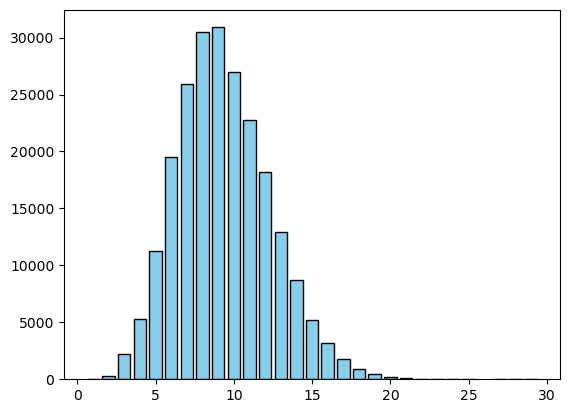

In [165]:
# word length distribution
lengths = list(word_count_dict.keys())
frequencies = [len(words) for words in word_count_dict.values()]

plt.bar(lengths, frequencies, color='skyblue', edgecolor='black')

(array([1.2490e+03, 2.0000e+00, 6.8100e+02, 1.7410e+03, 6.7780e+03,
        3.2538e+04, 3.5853e+04, 3.6370e+04, 6.0189e+04, 1.2807e+04,
        2.8992e+04, 7.8220e+03, 7.7600e+02, 1.1180e+03, 1.0800e+02,
        1.8300e+02, 5.4000e+01, 1.0000e+00, 0.0000e+00]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
 <BarContainer object of 19 artists>)

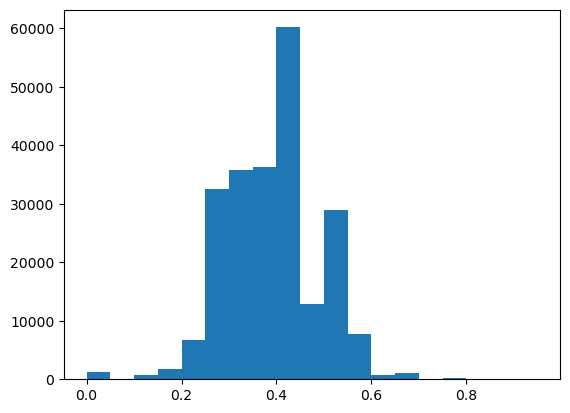

In [167]:
bins = np.arange(0.0, 1.0, 0.05)
plt.hist(x = bar, bins = bins)

In [171]:
def letter_ngrams(word, n):
    ngrams = [word[i:i+n] for i in range(len(word)-n+1)]
    return ngrams

def count_ngrams(wordlist, n):

    all_ngrams = []
    for word in wordlist:
        ngrams = letter_ngrams(word, n)
        all_ngrams.extend(ngrams)
    return Counter(all_ngrams)

In [173]:

class Config:
    """ User config class """
    def __init__(self, path: str=None): 
        
        self.model = 'lstm' #or 'transformer'
        self.lossfn = 'mse' #or 'mse'
        self.batch_size = 128
        self.learning_rate = 1e-4
        self.num_episodes = 100000
        self.mem_capacity = 10000
        self.train_steps = 2000000
        self.warmup = 15
        self.gamma = 0.998 #for the learning rate
        
        #for exploit vs explore
        self.starteps = 0.8
        self.endeps = 0.05
        self.decay_eps = 200
        
        self.target_update_freq = 1000
        self.save_freq = 1000
        self.save_file_name = 'train_new.pth'
    


In [175]:
class ReplayMemory:
    ''' Also for training.
    '''

    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Save aone instance of transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        """Randomly sample a batch of transitions."""
        return rnd.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [177]:
class n_gram():
    '''
    Classic statistic method in case for the love of God NN isn't the best fit.
    Also can be used to help with training the RL agent.
    '''
    

    def __init__(self, dictionary, list_to_exclude=[], trimlength=-1):

        if trimlength == -1:
            pass
        else:
            new_dict = []
            for word in dictionary:
                if len(word) == trimlength:
                    new_dict.append(word)
            dictionary = new_dict
        
        self.full_dict = dictionary #give me a list
        self.dict_clean_up(list_to_exclude)
        self.make_grams()
        

    def dict_clean_up(self, list_to_exclude):
        '''
        input = a list of letters
        re-create everything excluding the letter that we don't want.
        '''
        full = self.full_dict
        new_dict = []
        for word in full:
            logit = sum([1 if l in word else 0 for l in list_to_exclude])
            if logit == 0:
                new_dict.append(word)
                
        self.full_dict = new_dict
                
    
    def make_grams(self):

        self.unigram = count_ngrams(self.full_dict, 1)
        self.bigram = count_ngrams(self.full_dict, 2)
        self.trigram = count_ngrams(self.full_dict, 3)
        self.quadgram = count_ngrams(self.full_dict, 4)
        self.pentagram = count_ngrams(self.full_dict, 5)

    


        
    def get_slice(self, word_state, slice_len):
        '''
        get the pattern around the blank words
        '''

        '''
        slice = []
        count = 0
        for k in word_state:
            if k == -1:
                break       
            count += 1
        '''
        count = len(word_state)
        slice = []

        
        for i in range(count-slice_len):
    
            if 26 in word_state[i:i+slice_len]:
                s = word_state[i:i+slice_len]
                st = ''
                flag = 0
                eq_ = sum([1 if n == 26 else 0 for n in s])
                if eq_ == 1:
                    for n in s:
                        if n == 26:
                            st += '.'
                        else:
                            st += chr(n+ord('a'))
                if st != '':
                    slice.append(st)
                
        return slice

    
    def ngram_probability(self, word_state, weight = [1/5, 2/5, 2/5, 1/5, 1/5 ]): 
        # create 1-5 gram


        # 1
        uni_p = [0 for i in range(26)]
        
        for letter, freq in self.unigram.items():
   
            uni_p[ord(letter)-ord('a')] = freq
        uni_p = np.array(uni_p)/(sum(uni_p)+1e-9)

        # 2
        bi_p = [0 for i in range(26)]
        slice = self.get_slice(word_state, 2)
        matches = {}
        compiled_patterns = [re.compile(pattern) for pattern in slice]
        for pattern in compiled_patterns:
            for gram, count in self.bigram.items():
                if pattern.match(''.join(gram)):
                    matches[gram] = count
                    
        for keys in matches:
            for i in 'abcdeklmnfghijopqrstuvwxyz':
                if i in keys:
                    bi_p[ord(i)-ord('a')] += matches[keys]
        bi_p = np.array(bi_p)/(sum(bi_p) + 1e-9)
        #print(matches)

        # 3
        tri_p = [0 for i in range(26)]
        slice = self.get_slice(word_state, 3)
        matches = {}
        compiled_patterns = [re.compile(pattern) for pattern in slice]
        for pattern in compiled_patterns:
            for gram, count in self.trigram.items():
                if pattern.match(''.join(gram)):
                    matches[gram] = count
        #print(matches)
        for keys in matches:
            for i in 'abcdeklmnfghijopqrstuvwxyz':
                if i in keys:
                    tri_p[ord(i)-ord('a')] += matches[keys]
        tri_p = np.array(tri_p)/(sum(tri_p) + 1e-9)


        # 4
        quad_p = [0 for i in range(26)]
        slice = self.get_slice(word_state, 4)
        matches = {}
        
        compiled_patterns = [re.compile(pattern) for pattern in slice]
        for pattern in compiled_patterns:
            for gram, count in self.quadgram.items():
                if pattern.match(''.join(gram)):
                    matches[gram] = count
        #print(matches)       
        for keys in matches:
            for i in 'abcdeklmnfghijopqrstuvwxyz':
                if i in keys:
                    quad_p[ord(i)-ord('a')] += matches[keys]
        quad_p = np.array(quad_p)/(sum(quad_p) + 1e-9)

        # 5
        penta_p = [0 for i in range(26)]
        slice = self.get_slice(word_state, 5)
        matches = {}
        
        compiled_patterns = [re.compile(pattern) for pattern in slice]
        for pattern in compiled_patterns:
            for gram, count in self.pentagram.items():
                if pattern.match(''.join(gram)):
                    matches[gram] = count
        #print(matches)       
        for keys in matches:
            for i in 'abcdeklmnfghijopqrstuvwxyz':
                if i in keys:
                    quad_p[ord(i)-ord('a')] += matches[keys]
        penta_p = np.array(penta_p)/(sum(penta_p) + 1e-9)


        probability = weight[0]*uni_p + weight[1]*bi_p + weight[2]*tri_p + weight[3]*quad_p + weight[4]*penta_p

     
        return probability
        

In [179]:
class DQN(nn.Module):
    def __init__(self, state_size=27, action_size=26):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size+action_size+1, 32)
        self.conv = nn.Conv1d(in_channels=1, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.lstm = nn.LSTM(3*32, 3*32,  batch_first=True)
        
        self.flatten = nn.Flatten()
        self.fc2 = nn.Linear(3*32, action_size)

    def initialize_weights(self):
        # Initialize fully connected layers using Xavier initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
       
        x = self.conv (x.reshape(-1,1,32))

        x, _ = self.lstm(x.reshape(-1,1,3*32))

        x = self.fc2(x.squeeze(0))

        return x



In [181]:
class Hangman_Env(gym.Env):
    """Custom Hangman game Environment that follows gym interface."""
    
    metadata = {'render.modes': ['human']}
    
    def __init__(self, dict_file = None, MaxLen = 27):
        """Initialize the hangman game environment. """
        
        
        super(Hangman_Env, self).__init__()
       
        self.action_space = Discrete(26)  # the alphabet a-z = ord(x)-ord('a')
        
        self.observation_space = Tuple((
			MultiDiscrete(np.array([27]*MaxLen)),  # The state space of strings  
			MultiBinary([2]*26),# Guessed letters a-z guessed 1 unguessed 0
            Discrete(6 + 1) # attempt left = 0-6
            )) 
        #Example
        #observation 0: a___e = [0 26 26 26 4 0000000..]
        #observation 1:  only a and e are guessed [1 0 0 0 1 0000]
        #observation 2: 3 attemps are left [3]
        
        if dict_file is None:
            self.dictionary = list('no training dictionary for this game')
        else:
            f = open(dict_file, 'r').readlines()
            self.dictionary = [word.strip() for word in f]
            self.dictionary = random.sample(self.dictionary, len(self.dictionary))
        
        self.curr_word = ""
        self.unknown_word = []
        self.guessed_letters = np.zeros(26, dtype=int)
        self.attempts_left = 6
        self.win = False
        self.MaxLen = MaxLen
            
        self.reset()

    def reset(self, word_to_guess = None):
        """Reset the state of the environment to an initial state"""
        # Choose a random word from the list
        if word_to_guess == None:
            self.curr_word = rnd.choice(self.dictionary) 
        else:
            self.curr_word = word_to_guess
        
        self.unknown_word = ['_'] * len(self.curr_word)  # Hidden word representation
        self.guessed_letters = [0] * 26  # Initialize as all unguessed
        self.attempts_left = 6  # 6 guesses for each word
        logger.info("Reset: new word! new round!")
        logger.info("Reset: New word is [" + self.curr_word +"]")
        
        return self.get_observation()
    
    def step(self, action):
        
       assert self.action_space.contains(action), f"Invalid Action: {action} is not in the action space"
       # Just to help with debugging
       
       done = False
       reward = 0

       # Convert action to character
       char2guess = chr(action + ord('a'))

       # If the character was already guessed, return current state with no reward
       if self.guessed_letters[action] == 1:
           return self.get_observation(), reward, done, {}

       self.guessed_letters[action] = 1

       if char2guess in self.curr_word:
           # Correct guess
           reward = 3
           for idx, char in enumerate(self.curr_word):
               if char == char2guess:
                   self.unknown_word[idx] = char2guess
           if '_' not in self.unknown_word:
               done = True
               reward = 10  # Extra reward for winning
       else:
           # Incorrect guess
           self.attempts_left -= 1
           if self.attempts_left == 0:
               done = True
               reward = -10  # Penalty for losing
       
        

       return self.get_observation(), reward, done, {}
    
    def get_observation(self):
        
        unknown_word_logits = [26 if char == '_' else ord(char)-ord('a') for char in self.unknown_word]
        padding = [-1]*(self.MaxLen-len(unknown_word_logits))
        # 1 =  know 0 = unknown
        return torch.tensor(unknown_word_logits+padding), torch.tensor(self.guessed_letters), self.attempts_left, {}
    
    
    def render(self, mode='human'):
        unknown_word_str = " ".join(self.unknown_word)
        guessed_letters_str = ", ".join([chr(i + ord('a')) for i, val in enumerate(self.guessed_letters) if val == 1])
        print(f"Word: {unknown_word_str}")
        print(f"Guessed Letters: {guessed_letters_str}")
        print(f"Attempts Left: {self.attempts_left}")
        

In [205]:

class agent_hangman():
    '''
    so that I can play this thing locally.
    '''
    
    def __init__(self):
        
        en = Hangman_Env(dict_file = "words_250000_train.txt")
        self.config = Config() #alpha beta gamma batch_size
        self.state_size = 27
        self.action_size = 26
        self.memory = ReplayMemory(self.config.mem_capacity)
        self.step_count = 0
        self.episode_durations = []
        self.last_episode = 0
        self.reward_in_episode = []


        self.env = en
        self.id = int(time.time())
        
        
        #self.n_actions = self.env.action_space.n
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Use Double DQN and if it's an overshoot then switch back to usual dqn
        if self.config.model == 'transformer':
            self.transformerConfig = DecisionTransformerConfig( 
            state_dim = self.state_size, act_dim = self.action_size, hidden_size = 64, action_tanh = True, 
            vocab_size = 26, n_positions = 64, n_layer = 3, n_head = 4
            ) 
            self.policy_net = DecisionTransformerModel(self.transformerConfig).to(self.device)
            self.target_net = DecisionTransformerModel(self.transformerConfig).to(self.device)
        
        if self.config.model == 'lstm':
            self.policy_net = DQN().to(self.device)
            self.target_net = DQN().to(self.device)
            
        self.optimizer = optim.RMSprop(self.policy_net.parameters(),lr = 1e-4, alpha=0.99, eps=1e-8, weight_decay=1e-5)
        self.scheduler = lr_scheduler.ExponentialLR(self.optimizer, self.config.gamma)
        self.target_net.eval()
        
    def update_target_net(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

    
    def eps_scheduler(self):
        '''
        Adaptively balance explore or exploit, using exponential decay. For training purposes
        '''    
        return self.config.endeps + (self.config.starteps - self.config.endeps)*math.exp(-1. * self.step_count / self.config.decay_eps/100)

    
    def do_vowel(self, state):
        '''
        function to decide whether to select a vowel.
        '''
        l = len(self.env.curr_word)
        thres = l//2
        vowel_idx = [0,4,8,14,20]
        vowel_count = sum([1 if i in vowel_idx else 0 for i in state])
        return vowel_count < thres
        

    def heuristic_action(self, state):
        guessed = state[27:]

        
        select = rnd.choice([i for i in range(26)])
        while guessed[select] == 1:
            select = rnd.choice([i for i in range(26)])
        return select
        
        '''
        state = state[0:27]
        if not self.do_vowel:
            letter_frequencies = 'tsnhrdmwgvlfbkpxczjyq' #adjusted for training to leveral explore vs. exploit
        else:
            letter_frequencies = 'eitsanhurdmwgvlfbkopxczjyq'
        
        for idx in range(len(letter_frequencies)):
            char = ord(letter_frequencies[idx]) - ord('a')
            if self.env.guessed_letters[char] == 0:
                return ord(letter_frequencies[idx]) - ord('a') '''


    def correct_letter(self,state):
        ''' The list of correct guess
        '''
        correct = []
        state = state[0:27]
        for i in state:
            if 0<=i<=25:
                correct.append(chr(i+ord('a')))
        return correct

   

    def act_stat(self, state):
        '''
        Statistical method. 1# to provide instances for RL. 2# RL may not be a good approach for this problem.
        '''
        state = state[0:27]

        # find length
        l = len(self.env.curr_word)

        dictionary = word_count_dict[l] #n-dictionary created outside the function.
        pattern = ''
    
        for logit in state:
            if logit == 26:
                pattern += '.'
            elif logit == -1:
                pass
            else:
                pattern += chr(logit+ord('a'))

    
        selected_dictionary = []
        for wrd in dictionary:
    
            # match pattern
            if re.match(pattern,wrd):
                selected_dictionary.append(wrd)
        

        # use this to update the n-grams
        guessed = [chr(idx + ord('a')) for idx in range(26) if self.env.guessed_letters[idx] == 1]
        correct = self.correct_letter(state)
        wrong = list(set(guessed)-set(correct))

        vowel_idx = [0,4,8,14,20]
        vowel_count = sum([1 if state[idx] in [0,4,8,14,20] else 0 for idx in range(27)])
        guess_vowel = vowel_count < 0.55 #test against 0.5 and 0.45

        
        N_gram = n_gram(selected_dictionary)
        
        unigram = N_gram.unigram.most_common()
      

        
        action = -1 #nothing is done if action = -1
        
        # return most frequently letter in possible selection of words
        for letter, freq in unigram:
            if letter not in guessed:
                code = ord(letter)-ord('a')
                if code in vowel_idx and not guess_vowel: 
                    action = code
                    continue
                action = code
                break
        
        
        if action  == -1: #l gram
       
            substring_dict = self.sub_dictionary(word_list, pattern)
            l_gram = n_gram(substring_dict) 
            l_unigram = l_gram.unigram.most_common()
       
            for letter, freq in l_unigram:
                if letter not in guessed:
                    code = ord(letter)-ord('a')
                    if code in vowel_idx and not guess_vowel:
                        action = code
                        continue
                    action = code
                    break

        
        # Shorter substring.....
        if action  == -1:
       
            k = 5

            subsubstring_dict = []
            for idx in range(l-k+1):
                subpattern = pattern[idx:idx+k]
                subsubstring_dict += self.sub_dictionary(word_list, subpattern)
                
            l_gram = n_gram(subsubstring_dict) 
            l_unigram = l_gram.unigram.most_common()
        
            for letter, freq in l_unigram:
                if letter not in guessed:
                    code = ord(letter)-ord('a')
                    if code in vowel_idx and not guess_vowel:
                        action = code
                        continue
                    action = code
                    break
                    
        if action  == -1:
            k = 3
        
            subsubstring_dict = []
            for idx in range(l-k+1):
                subpattern = pattern[idx:idx+k]
                subsubstring_dict += self.sub_dictionary(word_list, subpattern)

            l_gram = n_gram(subsubstring_dict) 
            l_unigram = l_gram.unigram.most_common()
            for letter, freq in l_unigram.items():
                if letter not in guessed:
                    code = ord(letter)-ord('a')
                    if code in vowel_idx and not guess_vowel:
                        action = code
                        continue
                    action = code
                    break

        
        if action == -1:
            n_gram_act = n_gram(word_list)
            probability = n_gram_act.ngram_probability(state, weight = [1,0,0,0,0])
            sorted_act = np.argpartition(probability, -26)[-26:]
               
                #largest_k_elements = arr[largest_k_indices]
            for act in sorted_act:
                if chr(act+ord('a')) not in guessed:
                    action = act
                    
        return action
        

    def act(self, state, for_test = False):
        '''
        Select an action. This is the function to call when playing the game.
        '''
       
        sample = rnd.random()
        eps = self.eps_scheduler()*0
        if for_test:
            eps = 0.45
        self.step_count += 1
        countobs = sum([1 if k==26 else 0 for k in state])
        guess_vowel = self.do_vowel(state[0:27])

        vowel_idx = [0,4,8,14,20]
        vowel = sum([1 if self.env.guessed_letters[idx]== 1 else 0 for idx in [0,4,8,14,20] ])


        action = -1    
        if sample > eps: #exploit
            with torch.no_grad():
                action_sequence = self.policy_net(state.float())
                #selected_action = self.policy_net(state.float()).argmax() # what if I change it to select the max unguessed letter?? --08/27
                _, actions = torch.topk(action_sequence, 8, sorted = False)
                
                for action_idx in actions.squeeze().tolist():
                    if self.env.guessed_letters[action_idx] == 0:
                        if guess_vowel:
                            action = action_idx
                        else:
                            if action_idx not in [0,4,8,14,20]:
                                action = action_idx
                    else:
                        selected_action = self.heuristic_action(state) # set to random guess
                        action = selected_action
                        

        elif  eps*1/2 < sample < eps:
          
            selected_action = self.act_stat(state[0:27])
                
            action = selected_action

        
        else: #explore, using heuristic
   
            
            selected_action = self.heuristic_action(state) # set to random guess
 
            action = selected_action

        return action
        


    def train_n_play(self):
        '''
        The training loop
        '''
        
        #self.observation_space = Tuple((
		#	MultiDiscrete(np.array([MaxLen]*27)),  # The state space of strings 
		#	MultiBinary(26),                            # Guessed letters 0 or 1
        #    Discrete(6 + 1) # attempt left = 0-6
        #    )) 
        num_episodes = self.config.num_episodes
        self.episode_durations = []
        self.reward_in_episode = []
        reward_in_episode = 0
        for epi_idx in range(num_episodes):
            # episode start. Initiate env.
            state = self.env.reset()
           
            
            state = torch.cat((state[0], state[1], torch.tensor(state[2]).unsqueeze(0)), dim=0)
          
            count = -1
            while True:
                count += 1
                
                action = self.act_stat2(state)
          
                next_state, reward, done, _ = self.env.step(int(action))
         
                next_state = torch.cat((next_state[0], next_state[1],torch.tensor(next_state[2]).unsqueeze(0)), dim=0)

                # Store the transition
                self.memory.push(state, action, next_state, reward)
                
                if epi_idx >= self.config.warmup: 
                    self.replay()
                    self.scheduler.step()
                    done = (count > 28) or done
                else:
                    done = (count > 28) or done
                
                    

                
                # Move to the next state
                state = next_state
                reward_in_episode += reward

                if epi_idx % 1 == 0:
                    print('episode', epi_idx)
                    self.env.render()
                    print(self.eps_scheduler())
                
                

                if done:
                    self.episode_durations.append(count + 1)
                    self.reward_in_episode.append(reward_in_episode)
                    reward_in_episode = 0
                    break


                self.last_episode = epi_idx

                if done:
                    self.episode_durations.append(count + 1)

                    break
                
            # Update the target network
            if epi_idx % 100 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())
               
         
            if epi_idx % 100 == 0:
                self.save(self.config.save_file_name)
    

    def sub_dictionary(self, full_dict, word_pattern):
        '''
        create a subdictionary for high-quality prediction.
        '''
        
        full_dict
        new_dictionary = []
        l = len(word_pattern)
        for dict_word in full_dict:
            for i in range(len(dict_word)-l):
                if re.match(word_pattern,dict_word[i:i+l]):
                    new_dictionary.append(dict_word[i:i+l])
        return new_dictionary

    
    def replay(self):
        """
        essentially,
        the training loop
        """
        
        batch_size = self.config.batch_size
        if len(self.memory) < batch_size:
            return
        transitions = self.memory.sample(batch_size)

        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))
        
        
        non_empty_indicator = torch.tensor([1 if s is not None else 0 for s in batch.next_state], device=self.device, dtype=torch.bool)
        
        cat_next_states = torch.cat([s.clone().detach() for s in batch.next_state if s is not None])
        
        # collate
        cat_state = torch.cat(batch.state)
   
        cat_action  = torch.tensor(batch.action)

    
        cat_reward = torch.tensor(batch.reward)
        cat_state.resize_(batch_size, 27+26+1).to(self.device).float().requires_grad_(True)
        cat_next_states.resize_(batch_size, 27+26+1).to(self.device).float().requires_grad_(True)
        
        # compute Q from policy_net
        curr_state_Q = self.policy_net(cat_state.float()).squeeze()[torch.arange(batch_size), cat_action] # 0827 the problem is this line.

        
        next_state_Q = torch.zeros(batch_size, device=self.device, dtype=torch.float)

        next_state_Q[non_empty_indicator] = self.target_net(cat_next_states.float()).squeeze().max(1)[0].detach()

        expected_curr_state_Q = (next_state_Q * self.config.gamma) + cat_reward

        # Try to switch betwwen Huber loss and MSE??
        if self.config.lossfn == 'huber':
            criterion = nn.SmoothL1Loss()
            loss = criterion(curr_state_Q, expected_curr_state_Q).float()

        if self.config.lossfn == 'mse':
            criterion = nn.MSELoss()
            loss = criterion(curr_state_Q, expected_curr_state_Q).float()
            
    
        self.optimizer.zero_grad()
        loss.backward()

   
        for name, param in self.policy_net.named_parameters():
 
            param.grad.data.clamp_(-1.1, 1.1)
  
        self.optimizer.step()
    
    def save(self, filename):
        torch.save({
            'policy': self.policy_net.state_dict(),
            'target': self.target_net.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            "reward": self.reward_in_episode,
            "episode_durations": self.episode_durations,
            "config": self.config
            }, filename)
        
    def load(self, filename = 'train_01.pth'):
        checkpoint = torch.load(filename)
        self.policy_net.load_state_dict(checkpoint['policy'])
        self.target_net.load_state_dict(checkpoint['target'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.reward_in_episode = checkpoint['reward']
        self.episode_durations = checkpoint['episode_durations']
        self.config = checkpoint['config']

   

   

        

    
        

In [207]:
# Let's first trained this askdjhg!@(*&asd with the 'word_250000_train_txt' 
train_instance = agent_hangman()
train_instance.load(filename = "train_160000.pth")


In [209]:
train_instance.train_n_play()


episode 0
Word: _ _ _ _ _
Guessed Letters: e
Attempts Left: 5
1.0
episode 0
Word: _ _ _ _ _
Guessed Letters: e, i
Attempts Left: 4
1.0
episode 0
Word: _ _ _ _ _
Guessed Letters: a, e, i
Attempts Left: 3
1.0
episode 0
Word: _ o _ _ _
Guessed Letters: a, e, i, o
Attempts Left: 3
1.0
episode 0
Word: _ o _ _ _
Guessed Letters: a, e, i, n, o
Attempts Left: 2
1.0
episode 0
Word: _ o _ _ _
Guessed Letters: a, e, i, n, o, r
Attempts Left: 1
1.0
episode 0
Word: _ o _ _ _
Guessed Letters: a, e, i, n, o, r, t
Attempts Left: 0
1.0


KeyboardInterrupt: 

In [ ]:
#helper functions for using the API and my game env

def to_guessed_letter(letterlist):
    ''' change self.guessed_letters
    '''
    ls = [0 for i in range(26)]
    for l in letterlist:
        ls[ord(l)-ord('a')] = 1
    return ls


def to_state(word):
    ls = [-1 for i in range(max(len(word),27))] 
    idx = 0
    for k in word:
        if k not in 'abcdefghijklmnopqrstuvwxyz':
            ls[idx] = 26
        else:
            ls[idx] = ord(k)-ord('a')
        idx += 1
    #shape torch.size([])
    return ls[0:27]



In [ ]:
import csv
filename = 'test_instances' + '.csv'
with open(filename, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)

